<a href="https://colab.research.google.com/github/eshal26/PCA-CNN/blob/main/VGG_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os
import shutil
import sklearn
from sklearn.model_selection import train_test_split

In [18]:
train_dir = 'train_dataset'
val_dir = 'validation_dataset'
test_dir = 'test_dataset'

# Define transformations for training, validation, and testing data
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.8238, 0.8539, 0.9391], std=[0.1325, 0.1437, 0.0529])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.8238, 0.8539, 0.9391], std=[0.1325, 0.1437, 0.0529])
])

# Create datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [19]:
from sklearn.decomposition import PCA, IncrementalPCA

class CustomVGGWithPCA(nn.Module):
    def __init__(self, num_classes=2, pca_components=40):
        super(CustomVGGWithPCA, self).__init__()

        # Feature extraction layers with added pooling to reduce dimensions
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 112x112x64

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 56x56x128

            # Additional pooling layer to reduce dimensionality further
            nn.MaxPool2d(kernel_size=4, stride=4)   # Output: 14x14x128
        )

        # Initialize PCA to None
        self.pca = None

        # Classifier layers
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(pca_components, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes)
        )

    def extract_features(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the features for PCA
        return x

    def forward(self, x):
        x = self.extract_features(x)
        device = x.device

        # Apply PCA if it is fitted
        if self.pca is not None:


            # Convert tensor to NumPy array (detach and move to CPU)
            x_cpu = x.detach().cpu().numpy()

            # Apply PCA transformation
            x_pca = self.pca.transform(x_cpu)  # Apply PCA transformation on NumPy array

            # Convert the transformed data back to PyTorch tensor
            x = torch.from_numpy(x_pca).to(device, dtype=torch.float32)
        else:
            raise RuntimeError("PCA must be fitted before the forward pass")

        x = self.classifier(x)
        return x

In [20]:
from sklearn.decomposition import IncrementalPCA

def fit_pca_on_train_data(train_loader, model, device, pca_components ,  batch_size=64):
    # Dynamically determine the number of features from a sample batch
    with torch.no_grad():
        sample_batch, _ = next(iter(train_loader))
        sample_features = model.extract_features(sample_batch.to(device))
        num_features = sample_features.shape[1]  # Get feature dimension from sample batch


    # Initialize IncrementalPCA with the number of features dynamically set
    ipca = IncrementalPCA(n_components=pca_components, batch_size=batch_size)

    # Process each batch and fit IncrementalPCA
    for images, _ in train_loader:
        images = images.to(device)
        with torch.no_grad():
            features = model.extract_features(images)
            features = features.detach().cpu().numpy()  # Convert to numpy array for IncrementalPCA
            ipca.partial_fit(features)  # Fit incrementally

    # Assign the fitted IncrementalPCA back to model’s PCA attribute
    model.pca = ipca
    print("PCA fitting completed on training data.")

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pca_components = 40
num_classes = 2

model = CustomVGGWithPCA(num_classes=num_classes, pca_components=pca_components).to(device)
fit_pca_on_train_data(train_loader,  model,  device, pca_components=pca_components)


PCA fitting completed on training data.


In [21]:
def plot_pca_feature_maps(model, sample_batch, num_components=10, device='cpu'):
    """
    Visualize PCA-transformed feature maps after all convolutional layers.
    Args:
    - model: Trained model with PCA fitted.
    - sample_batch: Batch of input images.
    - num_components: Number of PCA components to visualize.
    - device: Device for computation ('cpu' or 'cuda').
    """
    # Move sample batch to the appropriate device
    sample_batch = sample_batch.to(device)

    # Extract features using the model
    with torch.no_grad():
        final_features = model.extract_features(sample_batch)  # Shape could be (batch_size, flattened_size)

    # Print shape for debugging
    print(f"Extracted features shape: {final_features.shape}")

    if len(final_features.shape) == 4:  # If spatial dimensions exist
        batch_size, channels, height, width = final_features.shape
        final_features_flat = final_features.view(batch_size, -1)  # Flatten the features
    elif len(final_features.shape) == 2:  # Already flattened
        final_features_flat = final_features
    else:
        raise ValueError("Unexpected shape of extracted features")

    # Apply PCA transformation
    if model.pca is None:
        raise RuntimeError("PCA is not fitted. Run `fit_pca_on_train_data` first.")

    pca_transformed = model.pca.transform(final_features_flat.cpu().numpy())  # Shape: (batch_size, n_components)

    # Plot PCA-transformed feature maps
    num_components_to_plot = min(num_components, pca_transformed.shape[1])  # Limit to available components
    fig, axes = plt.subplots(1, num_components_to_plot, figsize=(15, 5))
    for i in range(num_components_to_plot):
        ax = axes[i]

        # Reshape PCA component into a 2D grid if possible
        size = int(np.sqrt(pca_transformed.shape[1]))  # Approximate square shape
        try:
            pca_component_2d = pca_transformed[:, i].reshape(size, size)
        except ValueError:
            pca_component_2d = pca_transformed[:, i].reshape(-1, 1)  # Fallback to 1D visualization

        ax.imshow(pca_component_2d, cmap='viridis')
        ax.set_title(f"PCA Component {i+1}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()


Epoch 1/40: Training Loss: 1.4382, Accuracy: 76.54%
Epoch 2/40: Training Loss: 0.9988, Accuracy: 78.07%
Epoch 3/40: Training Loss: 0.8328, Accuracy: 78.99%
Epoch 4/40: Training Loss: 0.6756, Accuracy: 78.76%
Epoch 5/40: Training Loss: 0.6352, Accuracy: 79.15%
Visualizing PCA feature maps after epoch 5...
Extracted features shape: torch.Size([64, 25088])


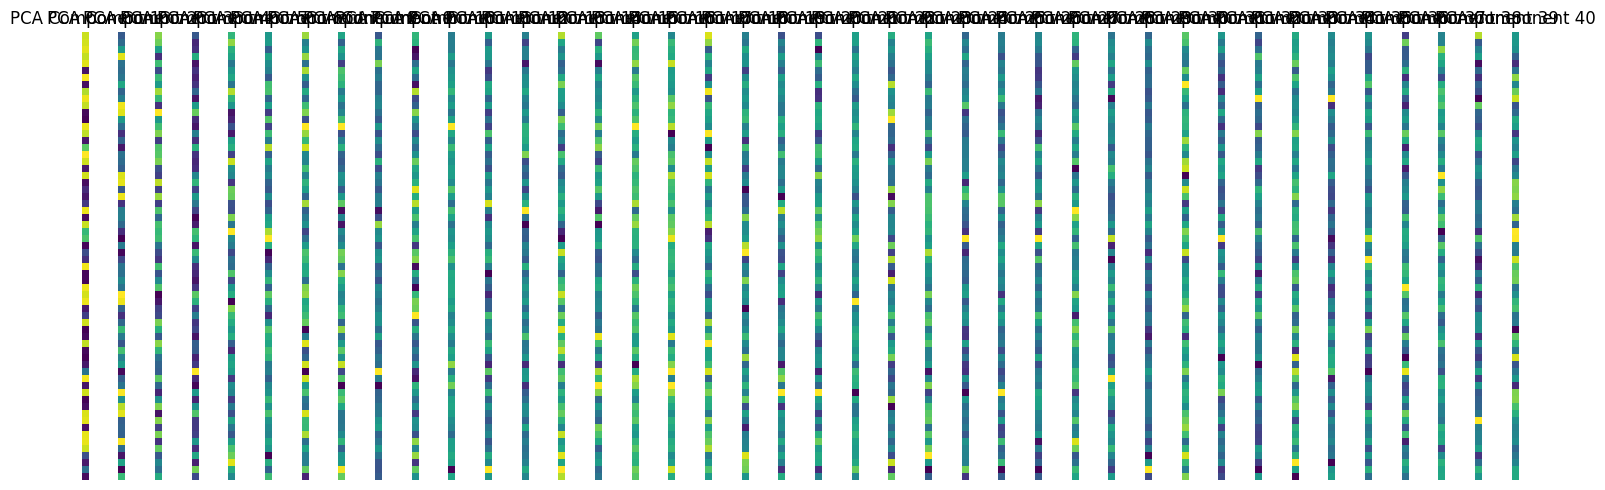

Epoch 6/40: Training Loss: 0.5633, Accuracy: 80.11%
Epoch 7/40: Training Loss: 0.5335, Accuracy: 80.49%
Epoch 8/40: Training Loss: 0.4791, Accuracy: 81.91%
Epoch 9/40: Training Loss: 0.4721, Accuracy: 81.87%
Epoch 10/40: Training Loss: 0.4819, Accuracy: 81.57%
Visualizing PCA feature maps after epoch 10...
Extracted features shape: torch.Size([64, 25088])


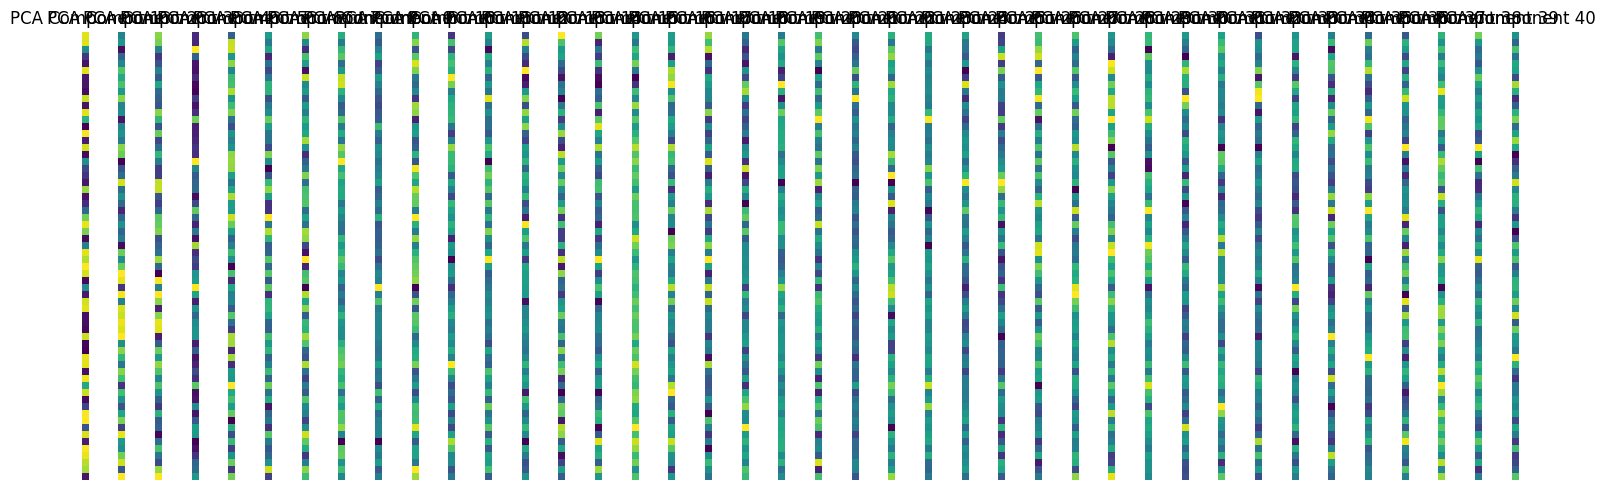

Epoch 11/40: Training Loss: 0.4639, Accuracy: 82.95%
Epoch 12/40: Training Loss: 0.4679, Accuracy: 82.72%
Epoch 13/40: Training Loss: 0.4746, Accuracy: 81.84%
Epoch 14/40: Training Loss: 0.4601, Accuracy: 82.76%
Epoch 15/40: Training Loss: 0.4729, Accuracy: 82.64%
Visualizing PCA feature maps after epoch 15...
Extracted features shape: torch.Size([64, 25088])


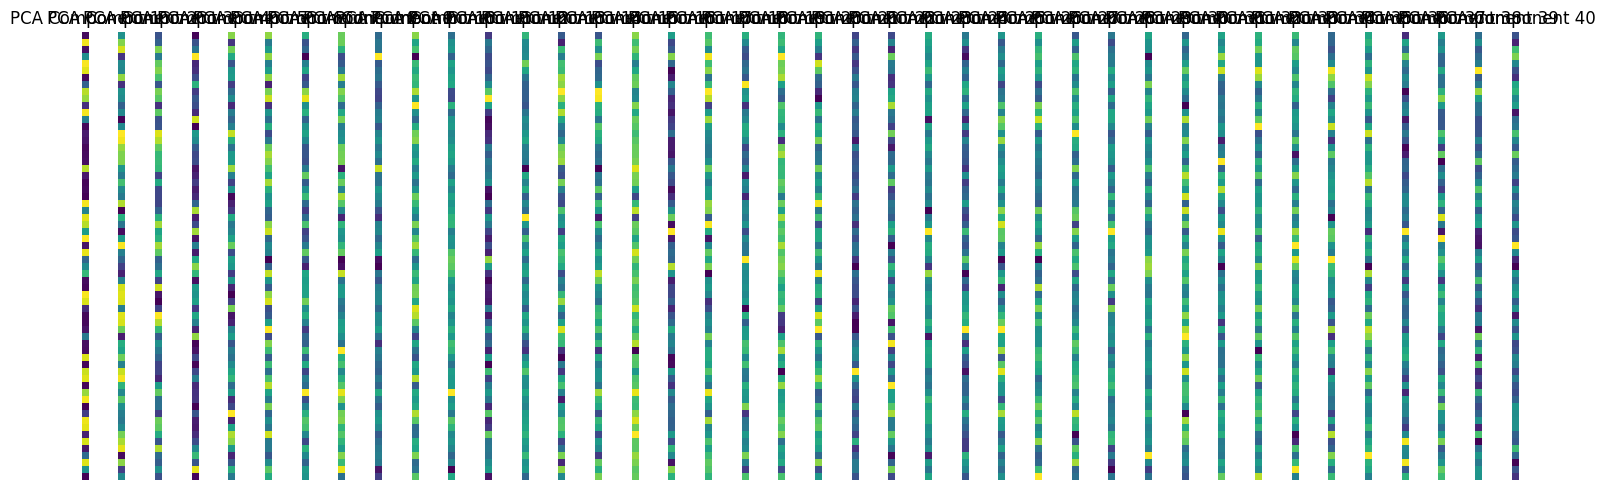

Epoch 16/40: Training Loss: 0.4405, Accuracy: 82.26%
Epoch 17/40: Training Loss: 0.4931, Accuracy: 81.72%
Epoch 18/40: Training Loss: 0.5095, Accuracy: 81.30%
Epoch 19/40: Training Loss: 0.4717, Accuracy: 81.41%
Epoch 20/40: Training Loss: 0.4322, Accuracy: 82.95%
Visualizing PCA feature maps after epoch 20...
Extracted features shape: torch.Size([64, 25088])


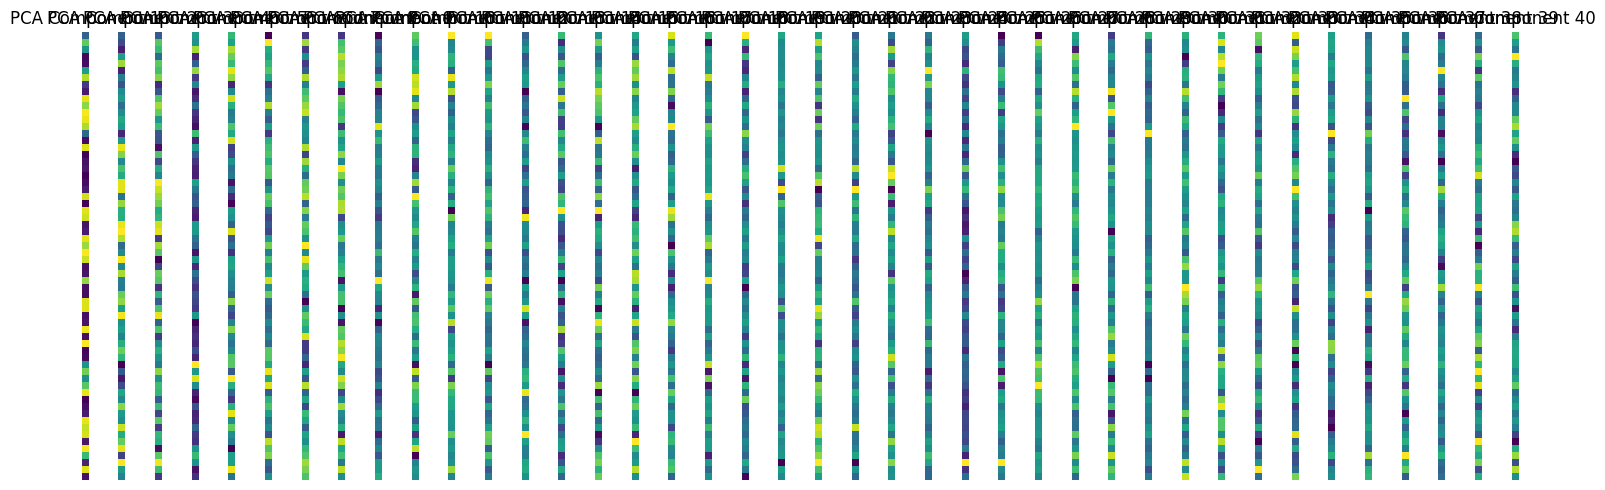

Epoch 21/40: Training Loss: 0.4397, Accuracy: 82.60%
Epoch 22/40: Training Loss: 0.4241, Accuracy: 82.72%
Epoch 23/40: Training Loss: 0.4354, Accuracy: 83.79%
Epoch 24/40: Training Loss: 0.4506, Accuracy: 83.37%
Epoch 25/40: Training Loss: 0.4423, Accuracy: 83.29%
Visualizing PCA feature maps after epoch 25...
Extracted features shape: torch.Size([64, 25088])


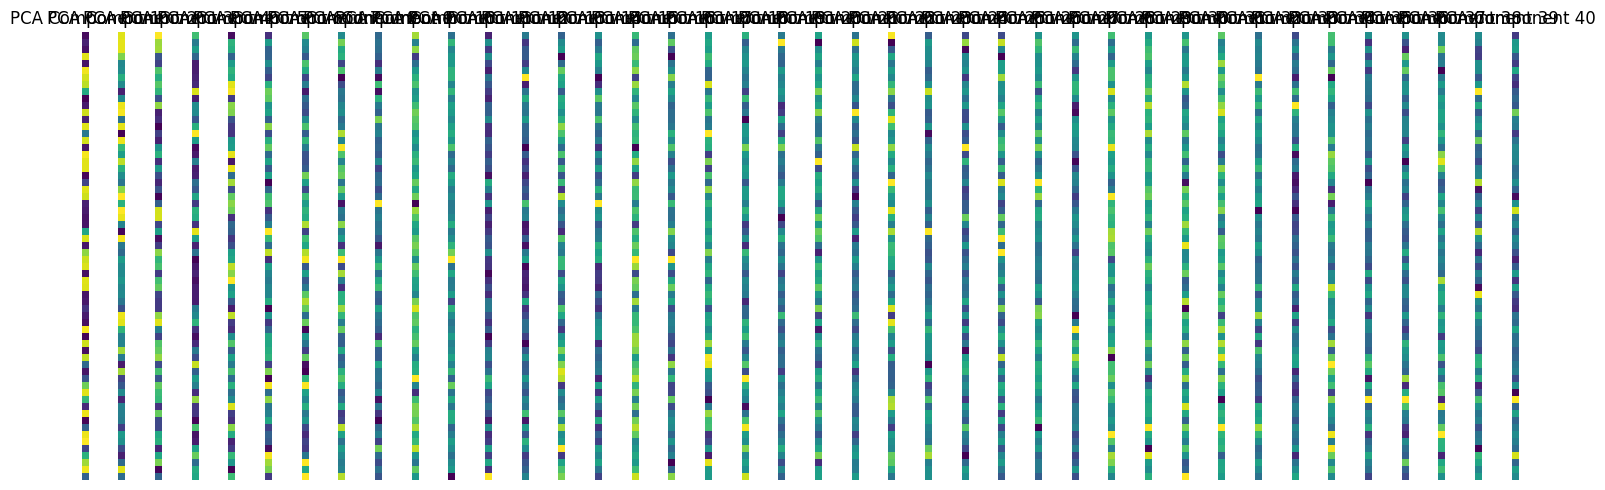

Epoch 26/40: Training Loss: 0.4750, Accuracy: 82.18%
Epoch 27/40: Training Loss: 0.4359, Accuracy: 82.87%
Epoch 28/40: Training Loss: 0.4161, Accuracy: 83.33%
Epoch 29/40: Training Loss: 0.4275, Accuracy: 83.18%
Epoch 30/40: Training Loss: 0.4246, Accuracy: 83.37%
Visualizing PCA feature maps after epoch 30...
Extracted features shape: torch.Size([64, 25088])


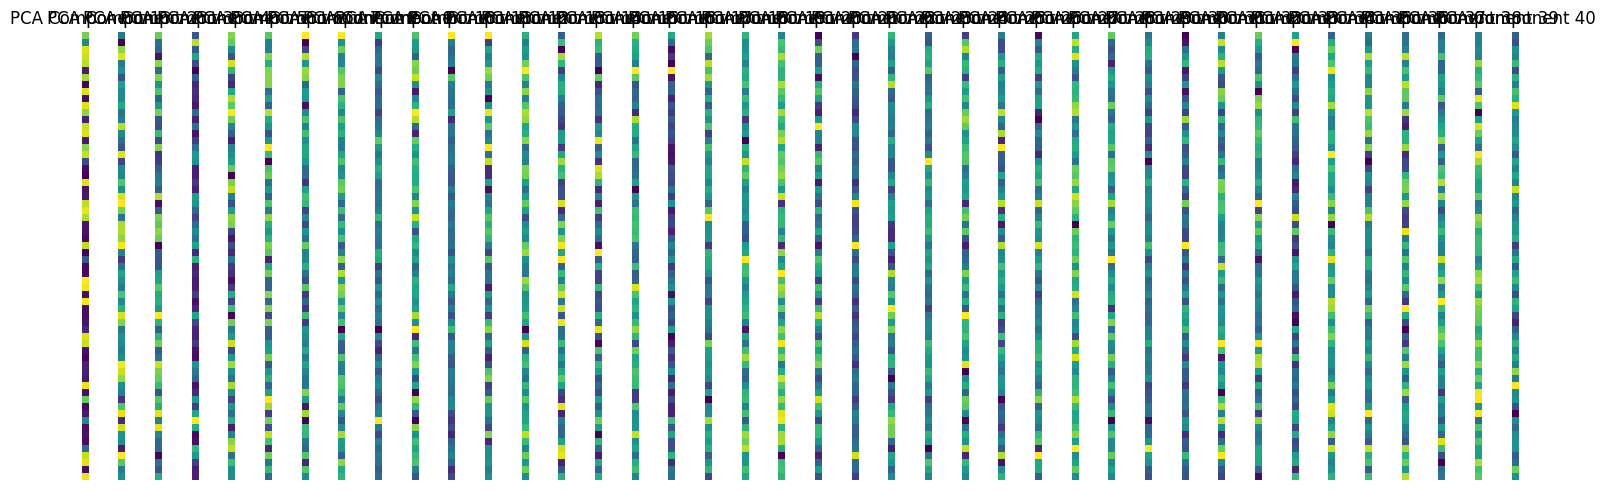

Epoch 31/40: Training Loss: 0.4513, Accuracy: 83.29%
Epoch 32/40: Training Loss: 0.4365, Accuracy: 82.83%
Epoch 33/40: Training Loss: 0.4210, Accuracy: 83.18%
Epoch 34/40: Training Loss: 0.4129, Accuracy: 83.60%
Epoch 35/40: Training Loss: 0.4284, Accuracy: 84.22%
Visualizing PCA feature maps after epoch 35...
Extracted features shape: torch.Size([64, 25088])


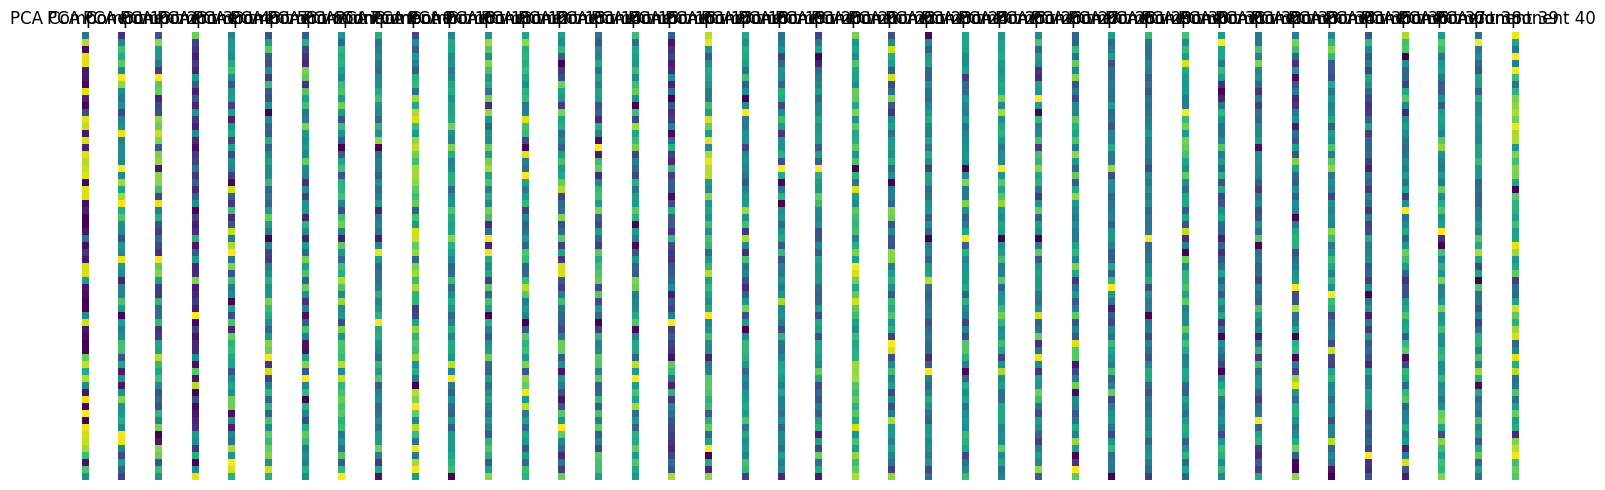

Epoch 36/40: Training Loss: 0.4298, Accuracy: 82.99%
Epoch 37/40: Training Loss: 0.4164, Accuracy: 83.53%
Epoch 38/40: Training Loss: 0.4151, Accuracy: 83.41%
Epoch 39/40: Training Loss: 0.4157, Accuracy: 83.87%
Epoch 40/40: Training Loss: 0.4217, Accuracy: 83.56%
Visualizing PCA feature maps after epoch 40...
Extracted features shape: torch.Size([64, 25088])


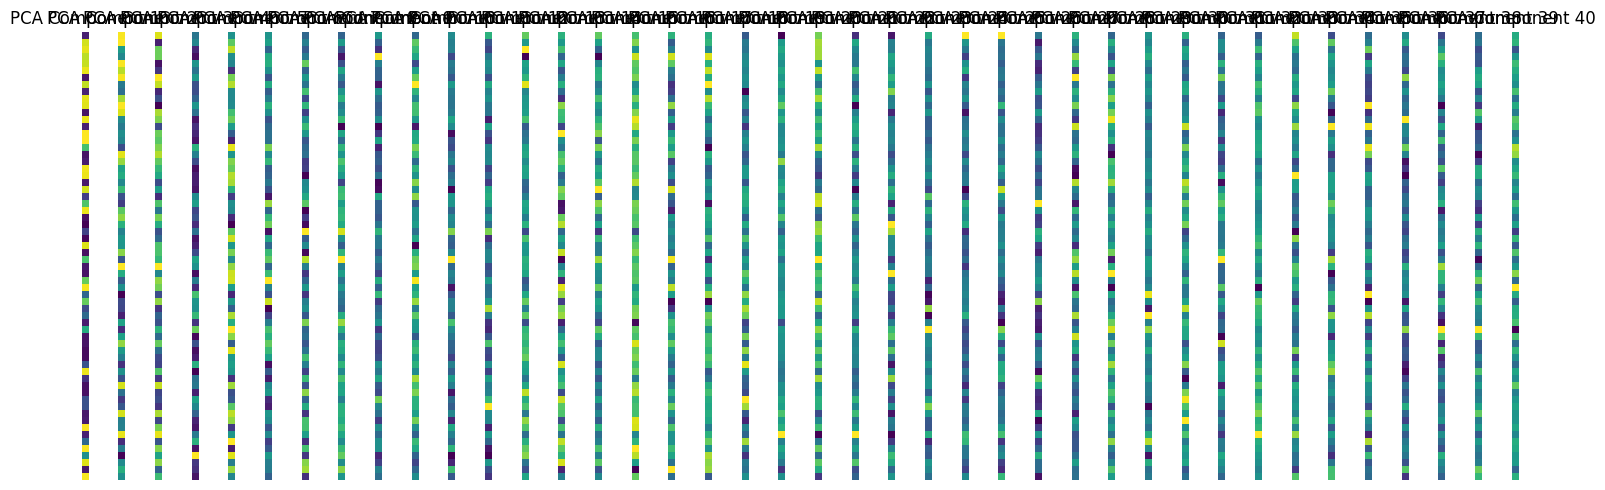

In [22]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct_predictions, total_samples = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = 100 * correct_predictions / total_samples
        print(f"Epoch {epoch+1}/{num_epochs}: Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
          # Example during training
         # Visualize PCA-transformed feature maps after every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f"Visualizing PCA feature maps after epoch {epoch+1}...")

            # Ensure PCA is fitted before plotting
            if model.pca is None:
                print("Skipping PCA visualization: PCA is not fitted yet.")
            else:
                sample_batch, _ = next(iter(train_loader))  # Get a sample batch from the training loader
                plot_pca_feature_maps(model, sample_batch, num_components=pca_components, device=device)



criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=40)
